In [2]:
import pandas as pd

df = pd.read_csv("/content/customer_support_tickets.csv")

# Convert to datetime
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], dayfirst=True, errors='coerce')
df['First Response Time'] = pd.to_datetime(df['First Response Time'], errors='coerce')
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'], errors='coerce')

df.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-01-06 12:15:00,NaT,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-01-06 16:45:00,NaT,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-01-06 11:14:00,2023-01-06 18:05:00,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-01-06 07:29:00,2023-01-06 01:57:00,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-01-06 00:12:00,2023-01-06 19:53:00,1.0


Build the EVENT LOG

In [3]:
events = []

for _, row in df.iterrows():
    case_id = row['Ticket ID']

    # Event 1: Ticket Created
    if pd.notnull(row['Date of Purchase']):
        events.append([case_id, 'Ticket Created', row['Date of Purchase']])

    # Event 2: First Response
    if pd.notnull(row['First Response Time']):
        events.append([case_id, 'First Response', row['First Response Time']])

    # Event 3: Ticket Closed
    if pd.notnull(row['Time to Resolution']):
        events.append([case_id, 'Ticket Closed', row['Time to Resolution']])

event_log = pd.DataFrame(
    events,
    columns=['case:concept:name', 'concept:name', 'time:timestamp']
)

event_log = event_log.sort_values(
    ['case:concept:name', 'time:timestamp']
)

event_log.head()


,case:concept:name,concept:name,time:timestamp
0,1,Ticket Created,2021-03-22 00:00:00
1,1,First Response,2023-01-06 12:15:00
2,2,Ticket Created,2021-05-22 00:00:00
3,2,First Response,2023-01-06 16:45:00
4,3,Ticket Created,2020-07-14 00:00:00


Convert to PM4Py log

In [7]:
!pip install pm4py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.3 MB/s eta 0:00:00


In [8]:
from pm4py.objects.conversion.log import converter as log_converter

In [9]:
pm_log = log_converter.apply(event_log)

Discover the process (Digital Process Twin)

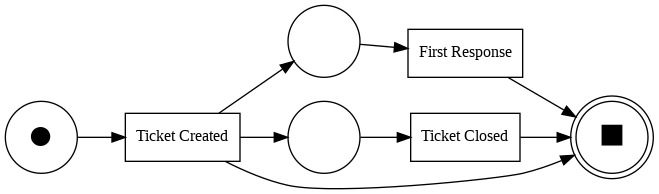

In [10]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

net, im, fm = alpha_miner.apply(pm_log)
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

Bottleneck / performance analysis

In [13]:
from pm4py.statistics.traces.generic.log import case_statistics

In [14]:
durations = case_statistics.get_all_case_durations(pm_log)

print("Average ticket cycle time (seconds):", sum(durations)/len(durations))
print("Max ticket cycle time (seconds):", max(durations))

Average ticket cycle time (seconds): 41853819.08607864
Max ticket cycle time (seconds): 95195040.0


Visualize delays

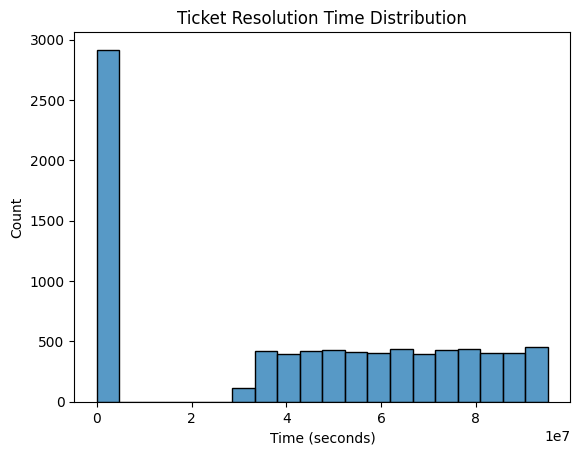

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(durations, bins=20)
plt.title("Ticket Resolution Time Distribution")
plt.xlabel("Time (seconds)")
plt.show()